# Previsão da qualidade de vinhos

Este notebook visa explorar o dataset de vinhos para compreender como cada característica dos mesmos impactam em sua qualidade. Além disso, a qualidade do vinho será prevista a partir de tais características. Para isso, usaremos técnicas de aprendizado supervisionado. Este documento é dividido da seguinte forma:

* Análise exploratória dos dados
* Análise da relação entre as variáveis
* Pré processamento dos dados
* Implementação e análise do modelo
* Conclusões
* Referências 

As linhas de código abaixo apenas carregam o dataset em memória e definem algumas funções úteis para esse projeto. Faremos um pequeno ajuste no nome das colunas para que sigam o padrão _snake_case_ e _lower case_ (padrão "pythônico").

In [4]:
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import re
import seaborn as sns
# import helper

from scipy.stats import chi2_contingency
from __future__ import division
from tmcm_feature_engineering import TMCMFeatureEng
from sklearn.model_selection import train_test_split

def slugify(c):
    # make strnig lower case
    c = c.lower()
    # remove unused white spaces
    c = c.strip()
    # replace multiple spaces with one
    c = re.sub('\s+', ' ', c)
    # replace spaces with underscore
    c = c.replace(" ", "_")
    return(c)

df = pd.read_csv("data/winequality.csv", sep=";")

rename_dict = {}
for c in df.columns:
    old_c = c
    new_c = slugify(c)
    rename_dict[old_c] = new_c
    
df = df.rename(columns=rename_dict)

In [5]:
df.dtypes

type                     object
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
ph                      float64
sulphates               float64
alcohol                  object
quality                   int64
dtype: object

## Análise exploratória dos dados

Nesta seção exploraremos as características básicas do dataset, não apenas suas dimensões mas também as suas variáveis. O dataset contém 6497 linhas e 13 colunas nas quais cada linha representa um vinho diferente com suas características e apresenta as seguintes colunas:

* `type`: tipo do vinho (categórica)
* `fixed acidity`: acidez fixa (numérica)
* `volatile_acitidy`: acidez volátil (numérica)
* `citric_acid`: quantidade de ácido cítrico (numérica)
* `residual_sugar`: quantidade de açúcar residual (numérica)
* `chlorides`: quantidade de cloretos (numérica)
* `free_sulfur_dioxide`: quantidade de dióxido sulfúrico livre (numérica)
* `total_sulfur_dioxide`: quantidade total de dióxido sulfúrico (numérica)
* `density`: densidade do vinho (numérica)
* `ph`: potencial de hidrogênio do vinho, ou seja, o quanto ele é ácido ou básico (numérica)
* `sulphates`: quantiadde de sulfato no vinho (numérica)
* `alcohol`: quantidade de álcool no vinho (numérica)
* `quality`: qualidade do vinho (categórica)

O código abaixo apresenta uma amostra dos dados sobre vinhos. É perceptível também a partir do código abaixo que todas as variáveis são 100% preenchidas com algum valor. Porém, é preciso de atentar a variável `alcohol` foi identificada pelo Pandas como `object` mas aparentemente ela deveria ser do tipo `float64` (numérica); investigaremos nas próximas seções por que isso deve estar acontencendo. 

In [6]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
def calculate_density(df):
    sparsity_dict = {}
    for col in df.columns:
        sparsity_dict[col] = df[col].count()/df.shape[0]
    return(sparsity_dict)

density_dict = calculate_density(df)
sorted_density_list = sorted(density_dict.items(), key=lambda x: x[1])

print("\n")
for l in sorted_density_list:
    print("{:25} => Density of {:4.2f}%".format(l[0], l[1]*100))



alcohol                   => Density of 100.00%
chlorides                 => Density of 100.00%
density                   => Density of 100.00%
quality                   => Density of 100.00%
sulphates                 => Density of 100.00%
fixed_acidity             => Density of 100.00%
free_sulfur_dioxide       => Density of 100.00%
residual_sugar            => Density of 100.00%
volatile_acidity          => Density of 100.00%
ph                        => Density of 100.00%
total_sulfur_dioxide      => Density of 100.00%
type                      => Density of 100.00%
citric_acid               => Density of 100.00%


### Explorando variável target: quality

A descrição do desafio informa que a variável `quality` pode receber valores inteiros que variam entre 0 e 10. Porém, como pode ser visto no gráfico abaixo, **não existem exemplos** no dataset de vinhos com qualidade entre 0 e 2 e nem com qualidade 10. Além disso, a distribuição dos valores de qualidade não é uniforme, havendo uma concentração de vinhos com qualidade 5, 6 e 6 (vinhos de certa forma medianos) e uma quantidade significativamente menor de vinhos de baixa qualidade e alta qualidade. Essas observações trazem as consequências abaixo para o modelo de aprendizado supervisionado:

* **Não será possível** prever qualidades 0, 1, 2 e 10, pois o modelo aprende a partir dos exemplos existentes
* Para garantir que as demais classes sejam previstas pelo modelo, teremos de usar uma **estratégia de segmentação estratificada** quando da quebra em treino e teste (será implementado nas próximas seções do estudo)
* O desafio não traz nenhuma informação extra sobre essa distribuição de qualidade dos vinhos. Dessa forma, **consideraremos que, de maneira geral, a qualidade dos vinhos segue uma distribuição normal** (ou seja, existe uma quantidade grande de vinhos medianos e alguns poucos que são muito bons ou muito ruins)

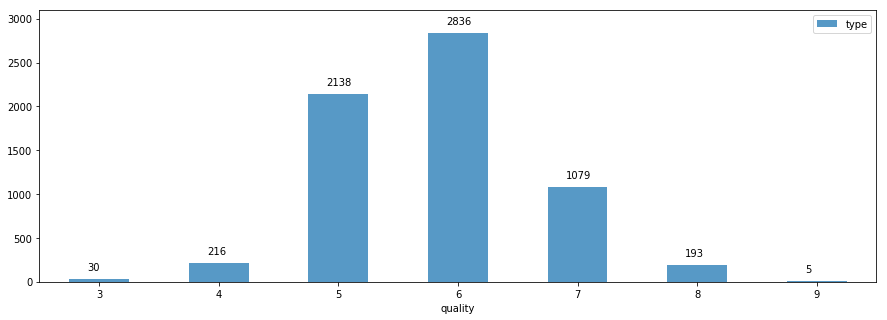

In [5]:
grouped_df = df.groupby('quality').agg({'type':'count'}).reset_index()

# plt.figure(figsize=(15,5))
ax = grouped_df.plot.bar(x='quality', figsize=(15,5), alpha=0.75, rot=0, ylim=(0,3100))
x_offset = -0.1
y_offset = 100
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

plt.show()

### Explorando variáveis categóricas

O código abaixo mostra que a variável `type` contém apenas dois valores possíveis: _White_ e _Red_. É possível notar também que 75% dos exemplos são de vinhos branco e os demais de vinho tinto. 

In [6]:
df_grouped = df.groupby('type').agg({'quality': 'count'}).reset_index().rename(columns={"quality": 'type_count'})
df_grouped['type_perc'] = (df_grouped['type_count']*100/df_grouped['type_count'].sum())
df_grouped.head()

,type,type_count,type_perc
0,Red,1599,24.611359
1,White,4898,75.388641


### Explorando variáveis numéricas

O código abaixo apresenta um resumo das variáveis numéricas do dataset. É importante notar que elas não estão na mesma escala, como é o caso das variáveis `volatile_acidity`, que possui valores entre 0.08 e 1.5, e `total_sulfur_dioxide`, que possui valores entre 6.0 e 44.0. Outro ponto interessante a ser notado é que algumas variáveis parecem ter _outliers_, tais como `total_sulfur_dioxide` e `free_sulfur_dioxide`, cujos valores máximos são muito superiores ao percentil de 99% (foi feito o histograma dessas duas variávels a título de exemplo). 

Uma consequência interessante dessas observações é que teremos de fazer transformações nos dados para que estejam na mesma escala. Essa atividade será feita mais adiante na etapa de pré processamento dos dados. 

In [16]:
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates"]

df[numeric_cols].describe(percentiles=[.25, .5, .75, .99])

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,1.710882,3.218501,0.531268
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,7.636088,0.160787,0.148806
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000
99%,12.000000,0.880000,0.740000,18.200000,0.186160,77.000000,238.000000,10.008000,3.640000,0.990000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000


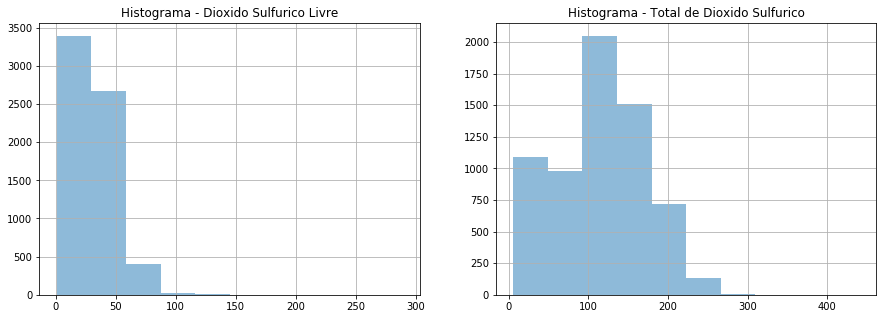

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df['free_sulfur_dioxide'].hist(alpha=.5, ax=axes[0])
axes[0].set_title('Histograma - Dioxido Sulfurico Livre')
df['total_sulfur_dioxide'].hist(alpha=.5, ax=axes[1])
axes[1].set_title('Histograma - Total de Dioxido Sulfurico')
plt.show()

### O caso da variável alcohol

Como citado anteriormente, a variável `alcohol` foi identificada pelo Pandas como `object` porém ela deveria ser `float64` (numérica). O código abaixo mostra que existem alguns valores anômalos no dataset, provavelmente advindos de medições inadequadas. Também é possível notar que os exemplos com dados equivocados correspondem a apenas 0,6% do todo. Para lidar com essa situação, iremos remover as linhas em que `alcohol_numeric == NaN`. 

In [7]:
df['alcohol_numeric'] = pd.to_numeric(df['alcohol'], errors='coerce')

In [8]:
df.loc[df['alcohol_numeric'].isnull(), ['alcohol', 'alcohol_numeric']].head(10)

,alcohol,alcohol_numeric
4315,128.933.333.333.333,NaN
4319,128.933.333.333.333,NaN
4323,114.666.666.666.667,NaN
4341,100.333.333.333.333,NaN
4353,114.333.333.333.333,NaN
4356,105.333.333.333.333,NaN
4358,953.333.333.333.333,NaN
4364,109.333.333.333.333,NaN
4369,109.333.333.333.333,NaN
4372,113.666.666.666.667,NaN


In [9]:
df.loc[df['alcohol_numeric'].notnull(), ['alcohol', 'alcohol_numeric']].head()

,alcohol,alcohol_numeric
0,8.8,8.8
1,9.5,9.5
2,10.1,10.1
3,9.9,9.9
4,9.9,9.9


In [10]:
errors_count = (df[df['alcohol_numeric'].isnull()].shape[0]*100)/df.shape[0]

print("Apenas {:2f}% das linhas contem dados inadequados de teor alcoolico".format(errors_count))

Apenas 0.615669% das linhas contem dados inadequados de teor alcoolico


In [11]:
df = df[df['alcohol_numeric'].notnull()]

## Relação entre as variáveis

Nesta seção vamos identificar como as variáveis preditoras se relacionam com a variável de destino (`quality`). Usaremos algns testes estatísticos para isso. Como `quality` é categórica, precisamos utilizar técnicas adequadas para este cenário: aplicaremos o teste Chi quadrado para variáveis categóricas e correlação de Spearman para as variáveis numéricas.

**<span style="color:red">[TODO - REVER]</span>** Esta análise servirá de input para decidirmos mais adiante quais variáveis manter e quais remover (_feature selection_). 

### Correlação para variáveis categóricas

O teste de independência do chi quadrado avalia de suas variáveis categóricas são relacionadas em uma população. Sua hipótese nula é de que as duas variáveis são independentes. Vamos aplicar o teste para as variáveis `type` e `quality` e usar o nível de significância de 0.05. É possível observar uma explicação básica deste neste em [[1]](#references)

Como pode ser visto no código abaixo, o p-value do teste é $8,66 \times 10^{-23}$, o que significa que devemos rejeitar a hipótese nula de que a variável `type_encoded` é independente da variável `quality`. Isso é um indicativo de que devemos manter a variável `type_encoded` no modelo.

In [10]:
def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

In [11]:
df['type_encoded'] = df['type'].apply(lambda x: 1 if x == "Red" else 2)

In [12]:
categorical_cols = ['type', 'quality']

chi2, p_value, dof, expected =  chisq_of_df_cols(df, 'type_encoded', 'quality')

print("p-value is: {}".format(p_value))

p-value is: 5.21718969513e-23


### Correlação para variáveis numéricas

Diferente da correlação de Pearson, adequada para comparação entre duas variáveis contínuas e com uma relação linear, a correlação de Spearman é adequada para variáveis ordinais e contínuas e avalia com que intensidade a relação entre duas variáveis pode ser descrita pelo uso de uma função monótona [[2]](#references). É possível observar uma explicação básica deste neste em [[3]](#references). 

O código abaixo cria uma matriz de correlação entre todas as variáveis numéricas e a variável output do dataset. A parte importante a ser observada é a última linha, que contém a correlação entre `quality` e todas as demais variáveis. Nela é possível notar alguns pontos:

* A variável álcool (`alcohol_numeric`) tem a maior correlação com `quality`. Densidade (`density`), cloretos (`chlorides`) e acidez volátil (`volatile_acidity`) também possuem correlação alta com `quality` porém são negativas, o que indica que são inversamente proporcionais
* A variável açúcar residual (`residual_sugar`) tem a menor correlação e ela também é negativa, o que indica que as variáveis são inversamente proporcionais. O açúcar residual também é a variável que tem correlação mais próxima de zero entre todas, o que é um indicativo de que podemos retirá-la do modelo que criaremos. 

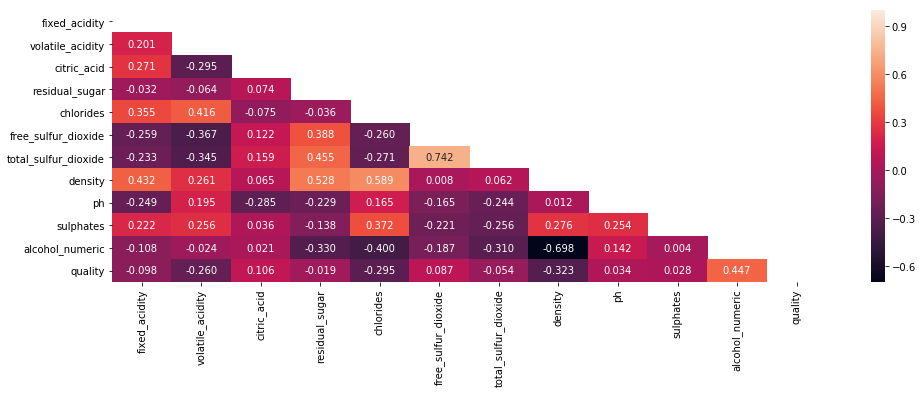

In [11]:
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol_numeric"]
output_col = ["quality"]

plt.figure(figsize=(16,5))
corr = df[numeric_cols+output_col].corr(method="spearman")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True, fmt= '.3f')
plt.show()

## Pré processamento dos dados

A partir das observações expostas na seção de análise exploratória dos dados nota-se que as variáveis numéricas estão em escalas diferentes, o que pode impactar no resultado dos modelos a ser criados. O código abaixo faz a normalização dos dados (mesmo procedimento do _Standard Scaler_ [[4]](#references) do sklearn). 

Outra atividade de pré-processamento que seria necessário é a transformação da variável `type` de string para número, porém isso já foi realizado acima (criou-se a variável `type_encoded`). 

In [12]:
suffix = "_scaled"
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol_numeric"]

for col in numeric_cols:
    df[col+suffix] = (df[col]-df[col].mean())/df[col].std()

In [13]:
df[[c for c in df.columns if "_scaled" in c]].head()

,fixed_acidity_scaled,volatile_acidity_scaled,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_numeric_scaled
0,-0.169490,-0.423124,0.283184,3.201730,-0.315616,0.816828,0.959608,-0.093261,-1.359021,-0.545236,-1.415875
1,-0.710068,-0.240963,0.145733,-0.807247,-0.201689,-0.928962,0.288173,-0.094174,0.506124,-0.276545,-0.829100
2,0.679989,-0.362403,0.558088,0.305192,-0.173207,-0.027909,-0.330254,-0.094031,0.257438,-0.612408,-0.326149
3,-0.015040,-0.666005,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799
4,-0.015040,-0.666005,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799


### Ponto de atenção com a variável categórica

Ao utilizar implementações computacionais dos algoritmos de classificação, temos que transformar as variáveis categóricas que estão em formato de string para um valor numérico. Porém, é difícil encontrar um valor numérico que possa representá adequadamente essas variáveis no dataset. Por exemplo, quando criamos a coluna `type_encoded` acima, atribuímos o valor `1` para vinho tinto e `2` para vinho branco, mas isso não significa que esses números tenham algum tipo de "representação de valor", ou seja, não temos como dizer que `1` está próximo de "vinho tinho". 
Para lidar com essa questão, vamos listar duas opções sugeridas na literatura científica:

* **1-of-K Coding**: consiste em transformar todas as variáveis categóricas em dummy vars. Esse método, apesar de ter resultados satisfatórios, aumenta drasticamente o número de variáveis presentes no dataset o que pode prejudicar a performance do algoritmo e também gerar overfitting. É possível ver uma descrição da técnica em [[5]](#references) (o artigo fala de _clustering_, mas a técnica pode ser usada em situações de aprendizado supervisionado também).
* **Two-step Method for Clustering Mixed numeric and categorical data (TMCM)** [[6]](#references): o algoritmo foi desenvolvido para conseguir lidar com variáveis categóricas e numéricas simultaneamente na clusterização. Ele é dividido em duas etapas principais: a primeira é a manipulação de variáveis categóricas de acordo com a teoria de co-ocorrência, que analisa o relacionamento entre as variáveis categóricas e gera um valor numérico razoável (e não binário) para elas; a segunda consiste na aplicação do K-means em duas etapas. Nesse estudo, foi feita a implementação da primeira etapa do algoritmo e o código pode ser encontrado no arquivo `tmcm_feature_engineering.py`. 

In [14]:
suffix = "_scaled"
numeric_cols = ["fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", "chlorides", 
                "free_sulfur_dioxide", "total_sulfur_dioxide", "density", "ph", "sulphates", "alcohol_numeric"]
numeric_cols = [c+suffix for c in numeric_cols]
categorical_cols = ['type']

obj = TMCMFeatureEng(df=df, categ_cols=categorical_cols, numeric_cols=numeric_cols)
df = obj.transform()

In [15]:
df.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,...,citric_acid_scaled,residual_sugar_scaled,chlorides_scaled,free_sulfur_dioxide_scaled,total_sulfur_dioxide_scaled,density_scaled,ph_scaled,sulphates_scaled,alcohol_numeric_scaled,type_tmcm
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,...,0.283184,3.201730,-0.315616,0.816828,0.959608,-0.093261,-1.359021,-0.545236,-1.415875,0.401024
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,...,0.145733,-0.807247,-0.201689,-0.928962,0.288173,-0.094174,0.506124,-0.276545,-0.829100,0.401024
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,...,0.558088,0.305192,-0.173207,-0.027909,-0.330254,-0.094031,0.257438,-0.612408,-0.326149,0.401024
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799,0.401024
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,...,0.008281,0.641022,0.054648,0.929459,1.242317,-0.093966,-0.177762,-0.881099,-0.493799,0.401024


## Implementação do modelo

Utilizaremos o modelo de árvores de decisão para resolver este desafio. Ele é um modelo não paramétrico de classificação e que aprende algumas regras de decisão a partir dos dados inputados no mesmo. Entre suas vantagens estão:

* Facilidade de interpretação (é possível explicar cenários usando lógica booleana)
* Capaz de lidar com um problema de multi classes como o deste desafio

Um grande trade-off desse modelo é a possibilidade de criar árvores demasiadamente complexas e que podem criar _overfitting_. Para evitar que isso aconteça, vamos desenhar as curvas de aprendizado de diferentes árvores treinadas e variando a altura da mesma (`max_depth`). 

Ademais, usaremos a entropia como **<span style="color:red">TODO</span>**

### Seleção de features

**<span style="color:red">TODO</span>** explicar que vamos usar as medidas estatísticas acima e dizer que poderiam também ser usados métodos de filtragem e wrapper methods. 

O código abaixo seleciona apenas as _features_ relevantes para o modelo.

In [16]:
features_cols = [c for c in df.columns if "_scaled" in c] + ["type_tmcm"]
output_col = 'quality'

X = df[features_cols]
y = df[output_col]

**<span style="color:red">TODO</span>** DIVISÃO DO DATASET ESTRATIFICADAMENTE

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y)

**<span style="color:red">TODO</span>** A partir das curvas de aprendizado abaixo percebe-se que os modelos com `max_depth >= COLOCAR VALOR AQUI` ...

In [ ]:
df_model1 = df2.copy()
X = df_model1.loc[:, df_model1.columns != 'INTERESTED']
y = df_model1['INTERESTED']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

title = "Learning Performances (Decision Tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

plot_learning_curve(title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4, max_depths=[5, 10], subset=True)
plot_learning_curve(title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4, max_depths=[20, 30], subset=False)

## [Referências](#references)

[1] How to calculate Chi Square Test for Independence (two way) - https://www.youtube.com/watch?v=xEiQn6sGM20

[2] Correlação de postos de Spearman - https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_postos_de_Spearman

[3] Spearman Correlation - https://www.youtube.com/watch?v=YpG2MlulP_o

[4] Standard Scaler - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[5] Wang, Fei & Franco, Hector & Pugh, John & Ross, Robert. (2016). Empirical Comparative Analysis of 1-of-K Coding and K-Prototypes in Categorical Clustering.

[6] A Two-Step Method for Clustering Mixed Categroical and Numeric Data

--

[2] Feature Selection Methods https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/

https://sebastianraschka.com/Articles/2014_python_lda.html

https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

https://medium.com/journey-2-artificial-intelligence/lda-linear-discriminant-analysis-using-python-2155cf5b6398

https://www.youtube.com/watch?v=YpG2MlulP_o

https://link.springer.com/chapter/10.1007/978-3-540-77226-2_19 (review de filter methods)

https://www.quora.com/What-are-some-good-error-metrics-for-multi-class-classification-when-you-have-many-objects-to-classify

In [13]:
%%html

<style>
span.text-red {
    color: red;
}

span.text-strike {
    text-decoration: line-through;
}

</style>

* <span class="text-red text-strike">Segmentar o dataset em treino e teste proporcionalmente às classes (strateified train_test_split)</span>
* <span class="text-red text-strike">Fazer limpeza na variável `alcohol` (tem uns valores inputados de forma esquisita), a ideia é remover eles</span>
* <span class="text-red text-strike">Fazer testes estatísticos para cada uma das variáveis preditoras</span>
* <span class="text-red text-strike">Fazer exploração do domínio de valores de cada variável</span>
* Explicar qual a função de custo (qual selecionei e por quê)
* Testar diferentes algoritmos e discorrer sobre o porquê da escolha
* Testar diferentes métodos de seleção de features (manualmente usando os testes estatísticos e SelectKBest do sklearn)
* Qual métrica de validação do modelo e por quê (avg_minor_f1_score)
* Remover outliers das variáveis de entrada
* Colocar os testes com diferentes features e algoritmos numa seção chamada "Variantes da solução"
* Futuros trabalhos - citar que é possível usar classes "bom" e "ruim" e reduzir o problema a uma classificaçao binomial
* <span class="text-red text-strike">Transformar variáveis categóricas em números</span>
* <span class="text-red text-strike">Usar técnica diferenciada para variáveis categóricas (encontrada no desafio do LuizaLabs)</span>
* <span class="text-red">Teste</span>

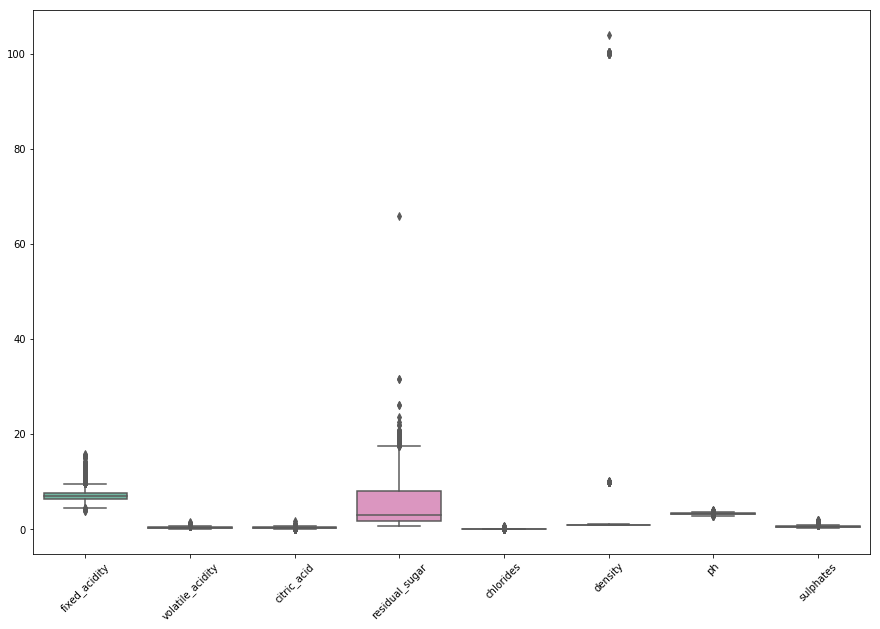

In [21]:
small_numeric_cols = [i for i in numeric_cols if i not in ["free_sulfur_dioxide", "total_sulfur_dioxide"]]
plt.figure(figsize=(15,10))
ax = sns.boxplot(data=df[small_numeric_cols], palette="Set2")
plt.xticks(rotation=45)
plt.show()

In [18]:
df[df['total_sulfur_dioxide'] == 440.0]

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
4745,White,6.1,0.26,0.25,2.9,0.047,289.0,440.0,0.99314,3.44,0.64,10.5,3


In [14]:
pd.to_numeric(df['alcohol'], errors='coerce')

0        8.8
1        9.5
2       10.1
3        9.9
4        9.9
5       10.1
6        9.6
7        8.8
8        9.5
9       11.0
10      12.0
11       9.7
12      10.8
13      12.4
14       9.7
15      11.4
16       9.6
17      12.8
18      11.3
19       9.5
20      12.8
21      11.0
22      10.5
23       9.3
24      10.0
25      10.4
26      10.0
27      10.5
28      11.6
29      12.3
        ... 
6467    11.5
6468    12.4
6469    11.1
6470     9.5
6471    12.5
6472    10.5
6473    11.8
6474    10.8
6475    11.9
6476    11.3
6477    11.3
6478    11.9
6479    11.3
6480    11.9
6481     9.8
6482    11.6
6483    11.5
6484    11.4
6485    10.9
6486    12.8
6487     9.2
6488    11.6
6489    11.6
6490    11.0
6491     9.5
6492    10.5
6493    11.2
6494    11.0
6495    10.2
6496    11.0
Name: alcohol, Length: 6497, dtype: float64